# Contextual Bandits

Before MDPs, we have bandit problems with context-dependent rewards but the context doesn't have action-dependent transitions (as an MDP would).

## Simulated Bandits

In [380]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [381]:
def sigmoid(x):
    return np.piecewise(
        x,
        [x > 0],
        [lambda i: 1 / (1 + np.exp(-i)), lambda i: np.exp(i) / (1 + np.exp(i))],
    )

In [382]:
def one_of_best(values):
    return np.random.choice(np.where(values==np.max(values))[0])

In [448]:
class ContextualBandit:
    """ k arms with d user features
    Rewards range from 0 to 1 OR are 0/1 following a binomial distribution. 
    """
    def __init__(self, k, d, bin=True, noise=None):
        self.k = k 
        self.d = d
        self.bin = bin

        self.a = np.random.randn(k, d)
        self.b = 2*np.random.randn(k)
        if noise is None:
            self.std_k = np.random.chisquare(1, k)
        else:
            self.std_k = noise * np.ones(k)
            
    def get_reward(self, arm, x, return_optimal=False):
        mu_k = np.sum(x*self.a, axis=1) + self.b
        if return_optimal:
            p_k = sigmoid(self.std_k * np.random.randn(self.k) + mu_k)
            if self.bin:
                r_k = np.random.binomial(1, p_k, self.k)
                return r_k[arm], np.max(r_k)
            return p_k[arm], np.max(p_k)
        p = sigmoid(self.std_k[arm] * np.random.randn() + mu_k[arm])
        if self.bin:
            return np.random.binomial(1, p)
        return p

    def get_context(self):
        return np.random.choice(2, (self.k, self.d))

In [449]:
k = 10
d = 20
bandit = ContextualBandit(k, d, bin=False, noise=0.1)

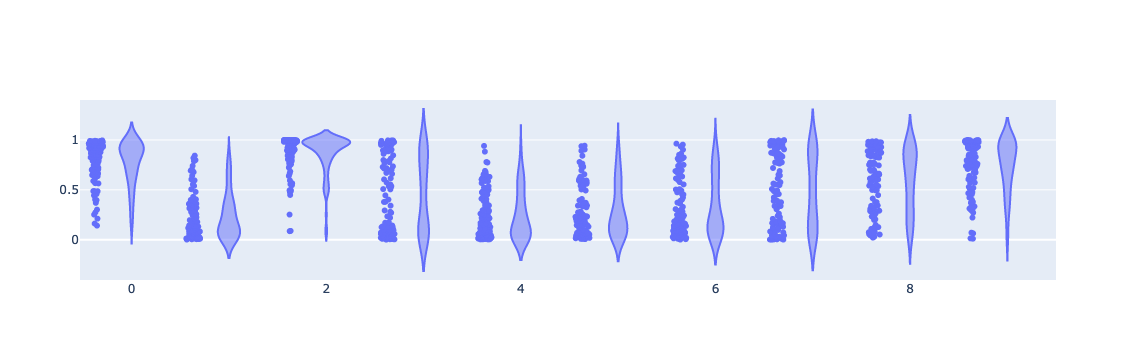

In [450]:
n=100
data = []

# for context in [np.zeros(2), np.array([0, 1]), np.array([1, 0]), np.ones(2)]:
rewards = []
arms = []
for arm in range(k):
    arms.extend([arm]*n)
    for _ in range(n):
        context = bandit.get_context()
        # for _ in range (n):
        rewards.append(bandit.get_reward(arm, context))
data.append(go.Violin(x=arms, y=rewards, points='all')) #, name=f'{context}'))

fig = go.Figure(data=data).show()

In [361]:
class ContextualBanditXZ:
    """ k arms with d user features and d_0 user/arm features.
    Rewards will range from 0 to 1 OR are 0/1 following a binomial distribution.
    """
    def __init__(self, k, d, d_0, bin=True, noise=None):
        self.k = k 
        self.d = d
        self.d_0 = d_0
        self.bin = bin

        self.a_i = np.random.randn(k, d)
        self.a_o = np.random.randn(d_0)
        self.b = 2*np.random.randn(k)
        if noise is None:
            self.std_k = np.random.chisquare(1, k)
        else:
            self.std_k = noise * np.ones(k)
            
    def get_reward(self, arm, x_k, z_k, return_optimal=False):
        mu_k = np.sum(self.a_i * x_k, axis=1) + np.dot(z_k, self.a_o) + self.b
        if return_optimal:
            p_k = sigmoid(self.std_k * np.random.randn(self.k) + mu_k)
            if self.bin:
                r_k = np.random.binomial(1, p_k, self.k)
                return r_k[arm], np.max(r_k)
            return p_k[arm], np.max(p_k)
        p = sigmoid(self.std_k[arm] * np.random.randn() + mu_k[arm])
        if self.bin:
            return np.random.binomial(1, p)
        return p

    def get_context(self):
        x_k = np.random.choice(2, (self.k, self.d))
        z_k = np.random.choice(2, (self.k, self.d_0))
        return x_k, z_k

In [371]:
k = 10
d = 2
d_0 = 3
bandit = ContextualBanditXZ(k, d, d_0, bin=False, noise=0.1)

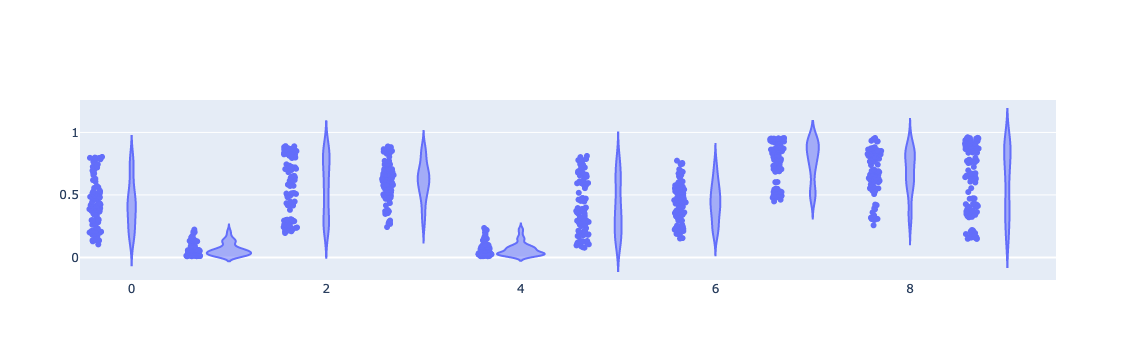

In [372]:
n=100
data = []

# for context in [np.zeros(2), np.array([0, 1]), np.array([1, 0]), np.ones(2)]:
rewards = []
arms = []
for arm in range(k):
    arms.extend([arm]*n)
    for _ in range(n):
        x, z = bandit.get_context()
        # for _ in range (n):
        rewards.append(bandit.get_reward(arm, x, z))
data.append(go.Violin(x=arms, y=rewards, points='all')) #, name=f'{context}'))

fig = go.Figure(data=data).show()

## LinUCB algorithms

Consider LinUCB from the Sept 21, 2023 reading group paper [*A Contextual-Bandit Approach to Personalized News Article Recommendation*](https://arxiv.org/abs/1003.0146) (2010).

In [442]:
class LinUCB:
    """ Algorithm 1 of the paper. 
    Differs by the addition gamma parameter than slowly forgets older data and weights the linear regression more strongly on recent data. 
    I purposefully allow the regularization to diminish at the same time. This simulatuneously curbs the incessant growth of the A and b terms.
    Set gamma to None to reduce to the algorithm of the paper. 
    Also, I tighten the bounds given that I have limited rewards to [0, 1].
    """
    def __init__(self, k, d, alpha, gamma=0.98, n_update=None):
        self.k = k
        self.d = d
        self.alpha = alpha
        self.gamma = gamma

        self.a = [np.eye(d) for _ in range(k)]
        self.a_inv = [np.eye(d) for _ in range(k)]
        self.b = [np.zeros(d) for _ in range(k)]
        
        self.n_update = d if n_update is None else n_update
        self.n = np.zeros(k)

    def next_action(self, x):
        theta_a = [np.matmul(a_inv, b) for a_inv, b in zip(self.a_inv, self.b)]
        p_a = np.array([np.dot(theta, x_a) 
                        + self.alpha * np.sqrt(2*np.dot(x_a, np.matmul(a_inv, x_a))/self.d)
              for x_a, theta, a_inv in zip(x, theta_a, self.a_inv)])
        return one_of_best(p_a)

    def update(self, arm, r, x):
        if self.gamma is not None:
            self.a[arm] *= self.gamma
            self.b[arm] *= self.gamma
        self.a[arm] += np.outer(x[arm], x[arm])
        self.b[arm] += r * x[arm]
        self.n[arm] += 1
        if np.mod(self.n[arm], self.n_update) == 0:
            self.a_inv[arm] = np.linalg.inv(self.a[arm])

    def simulate(self, cmab, steps):
        rewards = np.zeros(steps)
        r_opts = np.zeros(steps)
        for j in range(steps):
            x = cmab.get_context()
            a = self.next_action(x)
            r, r_opt = cmab.get_reward(a, x, return_optimal=True)
            r_opts[j] = r_opt
            rewards[j] = r
            self.update(a, r, x)
        return rewards, r_opts

In [451]:
k = 10
d = 4
bandit = ContextualBandit(k, d, bin=False, noise=0.1)

runs = 2000
n = 1000
rewards = {}
rewards_opt = {}
for gamma in [None, 0.98]:
    rewards[gamma] = np.zeros((runs, n))
    rewards_opt[gamma] = np.zeros((runs, n))
    for i in range(runs):
        rewards[gamma][i], rewards_opt[gamma][i] = LinUCB(k, d, alpha=1, gamma=gamma, n_update=1).simulate(bandit, n)

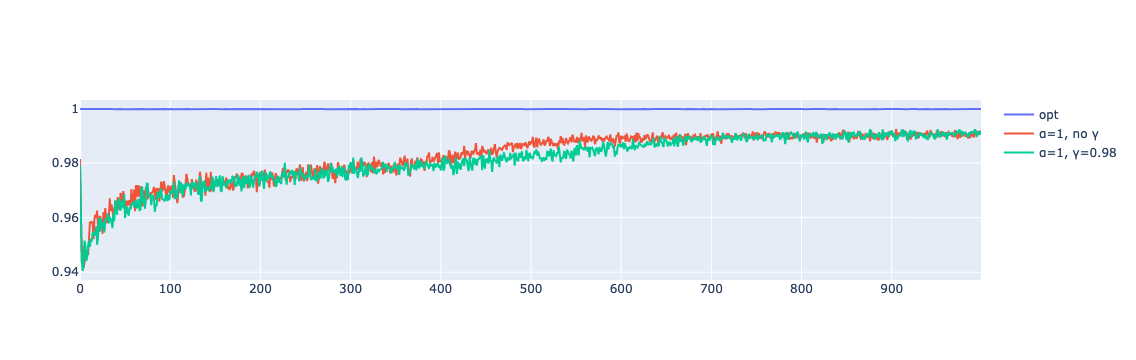

In [444]:
fig = go.Figure(data=[
    go.Scatter(x=np.arange(n), y=np.mean(rewards_opt[None], axis=0), name='opt'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards[None], axis=0), name='α=1, no γ'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards[0.98], axis=0), name='α=1, γ=0.98'),
]).show()

In [378]:
class LinUCBHybrid:
    """ Algorithm 2 of the paper. 
    Differs by the addition gamma parameter similarly to Algorithm 1.
    Also, I let the z context be d_0 dimensional (rather than setting to k as in the paper).
    Also, I tighten the bounds given that I have limited rewards to [0, 1].
    """
    def __init__(self, k, d, d_0, alpha, gamma, n_update=None):
        self.k = k
        self.d = d
        self.d_0 = d_0
        self.alpha = alpha
        self.gamma = gamma

        self.a_0, self.a_inv_0 = np.eye(d_0), np.eye(d_0)
        self.b_0 = np.zeros(d_0)
        self.a = [np.eye(d) for _ in range(k)]
        self.a_inv = [np.eye(d) for _ in range(k)]
        self.big_b = [np.zeros((d, d_0)) for _ in range(k)]
        self.b = [np.zeros(d) for _ in range(k)]
        
        self.n_update = d if n_update is None else n_update
        self.n = np.zeros(k)
    
    def next_action(self, x_k, z_k):
        beta = np.matmul(self.a_inv_0, self.b_0)
        p_k = np.zeros(self.k)
        for a, (x, z, a_inv, b, big_b) in enumerate(
            zip(x_k, z_k, self.a_inv, self.b, self.big_b)):
            theta = np.dot(a_inv, (b - np.dot(big_b, beta)))
            btax = np.dot(big_b.T, np.dot(a_inv, x)) 
            s = 2 / self.d * (
                np.dot(z, np.dot(self.a_inv_0, z - 2*btax)) +
                np.dot(x, np.dot(a_inv, x + 
                                 np.dot(big_b, np.dot(self.a_inv_0, btax))))
            )
            p_k[a] = np.dot(theta, x) + np.dot(z, beta) + self.alpha * np.sqrt(s)
        return one_of_best(p_k)

    def update(self, a, r, x_k, z_k):
        btainv = np.dot(self.big_b[a].T, self.a_inv[a])
        self.a_0 += np.dot(btainv, self.big_b[a])
        self.b_0 += np.dot(btainv, self.b[a])
        
        if self.gamma is not None:
            self.a[a] *= self.gamma
            self.big_b[a] *= self.gamma
            self.b[a] *= self.gamma
            self.a_0 *= self.gamma
            self.b_0 *= self.gamma
            
        self.a[a] += np.outer(x_k[a], x_k[a])
        self.big_b[a] += np.outer(x_k[a], z_k[a])
        self.b[a] += r * x_k[a]
        self.n[a] += 1
        
        if np.mod(self.n[a], self.n_update) == 0:
            self.a_inv[a] = np.linalg.inv(self.a[a])
        
        btainv = np.matmul(self.big_b[a].T, self.a_inv[a])
        self.a_0 += np.outer(z_k[a], z_k[a]) - np.matmul(btainv, self.big_b[a])
        self.b_0 += r * z_k[a] - np.matmul(btainv, self.b[a])
        
        if np.mod(np.sum(self.n), self.n_update) == 0:
            self.a_inv_0 = np.linalg.inv(self.a_0)

    def simulate(self, cmabxz, steps):
        rewards = np.zeros(steps)
        r_opts = np.zeros(steps)
        for j in range(steps):
            x, z = cmabxz.get_context()
            a = self.next_action(x, z)
            r, r_opt = cmabxz.get_reward(a, x, z, return_optimal=True)
            r_opts[j] = r_opt
            rewards[j] = r
            self.update(a, r, x, z)
        return rewards, r_opts

In [369]:
k = 5
d = 6
d_0 = 15
bandit = ContextualBanditXZ(k, d, d_0, bin=False, noise=0.1)

runs = 2000
n = 1000
rewards = {}
rewards_opt = {}
for gamma in [None, 0.98]:
    rewards[gamma] = np.zeros((runs, n))
    rewards_opt[gamma] = np.zeros((runs, n))
    for i in range(runs):
        rewards[gamma][i], rewards_opt[gamma][i] = LinUCBHybrid(k, d, d_0, alpha=1, gamma=gamma, n_update=1).simulate(bandit, n)

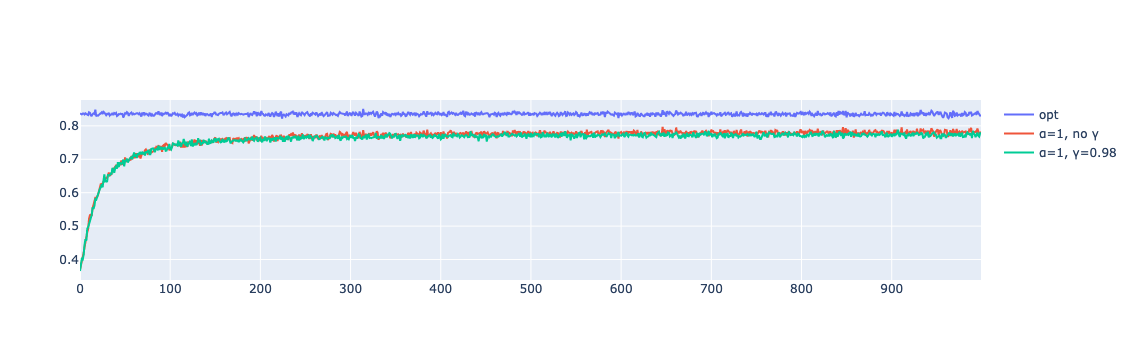

In [370]:
fig = go.Figure(data=[
    go.Scatter(x=np.arange(n), y=np.mean(rewards_opt[None], axis=0), name='opt'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards[None], axis=0), name='α=1, no γ'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards[0.98], axis=0), name='α=1, γ=0.98'),
]).show()

## Thompson Sampling

In [437]:
class ThompsonSampling:
    def __init__(self, k, d, delta):
        self.k = k
        self.d = d
        self.delta = delta
        self.B = np.eye(d)
        self.B_inv = np.eye(d)
        self.b = np.zeros(d)
        self.mu = np.zeros(d)
        self.t = 1
        self._v = 0.1

    def _v_t2(self):
        return self._v * np.log(self.t / self.delta)

    def next_action(self, x_i):
        r_sim = np.dot(x_i, np.random.multivariate_normal(self.mu, self._v_t2()*self.B_inv))
        return np.argmax(r_sim)

    def update(self, arm, r, x_i):
        self.t += 1
        self.B += np.outer(x_i[arm], x_i[arm])
        self.B_inv = np.linalg.inv(self.B)
        self.b += r * x_i[arm]
        self.mu = np.dot(self.B_inv, self.b)

    def simulate(self, cmab, steps):
        rewards = np.zeros(steps)
        r_opts = np.zeros(steps)
        for j in range(steps):
            x = cmab.get_context()
            a = self.next_action(x)
            r, r_opt = cmab.get_reward(a, x, return_optimal=True)
            r_opts[j] = r_opt
            rewards[j] = r
            self.update(a, r, x)
        return rewards, r_opts

In [452]:
# k = 10
# d = 20
# bandit = ContextualBandit(k, d, bin=False, noise=0.1)

runs = 2000
n = 1000
# rewards = {}
# rewards_opt = {}
# for gamma in [None, 0.98]:
rewards_TS = np.zeros((runs, n))
rewards_opt_TS = np.zeros((runs, n))
for i in range(runs):
    rewards_TS[i], rewards_opt_TS[i] = ThompsonSampling(k, d, 0.5).simulate(bandit, n)

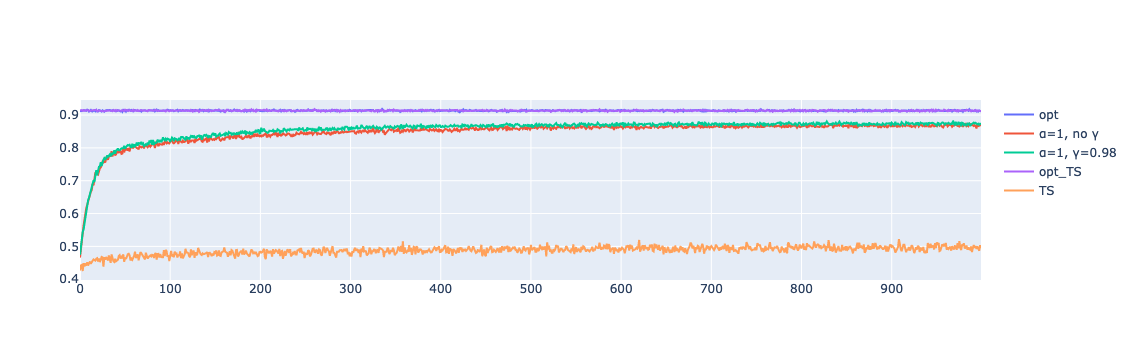

In [453]:
fig = go.Figure(data=[
    go.Scatter(x=np.arange(n), y=np.mean(rewards_opt[None], axis=0), name='opt'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards[None], axis=0), name='α=1, no γ'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards[0.98], axis=0), name='α=1, γ=0.98'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards_opt_TS, axis=0), name='opt_TS'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards_TS, axis=0), name='TS'),
]).show()